# Binary Classification of Insurance Cross Selling

**Goal**: The objective of this competition is to predict which customers respond positively to an automobile insurance offer.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import xgboost as xgb
from sklearn.metrics import roc_auc_score

In [2]:
train = pl.read_csv("./data/train.csv").drop('id')
# test = pl.read_csv("./data/test.csv").drop('id')

In [3]:
print(f'Train data:\nShape:\n{train.shape}')
print('=============================')
# print(f'Test data:\nShape:\n{test.shape}')

Train data:
Shape:
(11504798, 11)


In [4]:
train.describe()

statistic,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""count""","""11504798""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,"""11504798""","""11504798""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,38.383563,0.998022,26.41869,0.462997,null,null,30461.370411,112.425442,163.897744,0.122997
"""std""",null,14.993459,0.044431,12.99159,0.498629,null,null,16454.745205,54.035708,79.979531,0.328434
"""min""","""Female""",20.0,0.0,0.0,0.0,"""1-2 Year""","""No""",2630.0,1.0,10.0,0.0
"""25%""",null,24.0,1.0,15.0,0.0,null,null,25277.0,29.0,99.0,0.0
"""50%""",null,36.0,1.0,28.0,0.0,null,null,31824.0,151.0,166.0,0.0
"""75%""",null,49.0,1.0,35.0,1.0,null,null,39451.0,152.0,232.0,0.0
"""max""","""Male""",85.0,1.0,52.0,1.0,"""> 2 Years""","""Yes""",540165.0,163.0,299.0,1.0


In [5]:
train.head()

Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
str,i64,i64,f64,i64,str,str,f64,f64,i64,i64
"""Male""",21,1,35.0,0,"""1-2 Year""","""Yes""",65101.0,124.0,187,0
"""Male""",43,1,28.0,0,"""> 2 Years""","""Yes""",58911.0,26.0,288,1
"""Female""",25,1,14.0,1,"""< 1 Year""","""No""",38043.0,152.0,254,0
"""Female""",35,1,1.0,0,"""1-2 Year""","""Yes""",2630.0,156.0,76,0
"""Female""",36,1,15.0,1,"""1-2 Year""","""No""",31951.0,152.0,294,0


In [6]:
# Stuff that might have to be done
# OHE - Gender, Region_Code, Vehicle_Age, Vehicle Damage, 
# Scaling Annual Premium
# Check unique for Policy_Sales_Channel

In [7]:
train["Response"].value_counts() #very imbalanced

Response,count
i64,u32
1,1415059
0,10089739


In [8]:
train.select([pl.col(pl.INTEGER_DTYPES), pl.col(pl.FLOAT_DTYPES)]).columns

['Age',
 'Driving_License',
 'Previously_Insured',
 'Vintage',
 'Response',
 'Region_Code',
 'Annual_Premium',
 'Policy_Sales_Channel']

# EDA

In [9]:
# numeric_cols = ["Age", "Vintage", "Annual_Premium", "Policy_Sales_Channel"]
# sampled_train = train.sample(fraction=0.1)

In [10]:
# fig, ax = plt.subplots(4, 2, figsize=(20, 15))
# fig.tight_layout(pad=5.0)
# for i, col in enumerate(numeric_cols):
#     # Histogram
#     sns.histplot(data=sampled_train, x=col, ax=ax[i, 0])
#     ax[i, 0].set_title(f'{col} Distribution')
# 
#     # Box plot
#     sns.boxplot(data=sampled_train, x=col, ax=ax[i, 1])
#     ax[i, 1].set_title(f'{col} Box Plot')
# plt.show()

In [11]:
# # train.columns
# cat_cols = ["Gender", "Region_Code", "Vehicle_Age", "Vehicle_Damage", "Previously_Insured", "Driving_License"]

In [12]:
# fig, axs = plt.subplots(3, 2, figsize=(20, 15))
# fig.tight_layout(pad=5.0)
# 
# for i, col in enumerate(cat_cols):
#     row, col_num = divmod(i, 2)
#     sns.countplot(data=sampled_train, x=col, ax=axs[row, col_num])
#     axs[row, col_num].set_title(f'{col} Distribution')
# 
# plt.show()

In [13]:
# most of it is balanced, the driving license is almost 100% 1 tho.

In [14]:
train['Response'].value_counts()

Response,count
i64,u32
1,1415059
0,10089739


# Data Preprocessing

In [32]:
def preprocess(data):
    vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}

    data1 = data.with_columns(
        pl.col('Region_Code').cast(pl.UInt16),
        pl.col('Policy_Sales_Channel').cast(pl.UInt16),
        pl.col('Age').cast(pl.UInt16),
        pl.col('Response').cast(pl.UInt8),
        pl.col('Vintage').cast(pl.UInt16),
        pl.col('Previously_Insured').cast(pl.UInt8)
    )
    
    data2 = data1.with_columns(
        pl.col("Gender").map_elements(lambda x: 1 if x == "Male" else 0, return_dtype=pl.UInt8),
        pl.col("Vehicle_Damage").map_elements(lambda x: 1 if x == "Yes" else 0, return_dtype=pl.UInt8),
        pl.col("Vehicle_Age").map_elements(lambda x: vehicle_age_mapping.get(x), return_dtype = pl.UInt8)
    )

    data3 = data2.with_columns(
        pl.col("Annual_Premium").map_batches(lambda x: np.log1p(x), return_dtype=pl.Float64)
    )
    
    return data3

In [33]:
train2 = preprocess(train)

In [34]:
train2.estimated_size()

335077242

In [37]:
train2.describe()

statistic,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.541351,38.383563,0.998022,26.41869,0.462997,0.603107,0.50268,9.997924,112.425442,163.897744,0.122997
"""std""",0.498287,14.993459,0.044431,12.99159,0.498629,0.567856,0.499993,1.034031,54.035708,79.979531,0.328434
"""min""",0.0,20.0,0.0,0.0,0.0,0.0,0.0,7.875119,1.0,10.0,0.0
"""25%""",0.0,24.0,1.0,15.0,0.0,0.0,0.0,10.13769,29.0,99.0,0.0
"""50%""",1.0,36.0,1.0,28.0,0.0,1.0,1.0,10.368007,151.0,166.0,0.0
"""75%""",1.0,49.0,1.0,35.0,1.0,1.0,1.0,10.58284,152.0,232.0,0.0
"""max""",1.0,85.0,1.0,52.0,1.0,2.0,1.0,13.199632,163.0,299.0,1.0


In [ ]:
# Policy_Sales_Channel and Region_Code are still categorical. I feel. Will just train and see the importance.

In [39]:
train2['Policy_Sales_Channel'].n_unique()

152

In [41]:
train2['Region_Code'].n_unique()

53

In [46]:
cor = train2.to_pandas().corr()

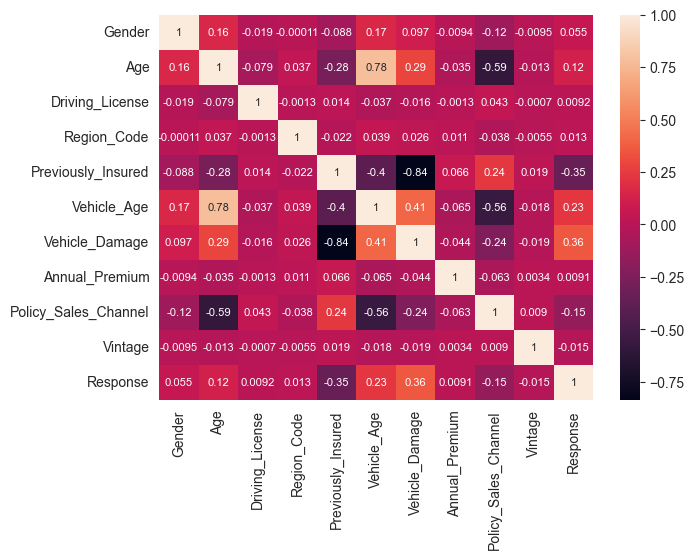

In [49]:
# plt.figure(figsize=(7, 5))  # Increase the figure size
# sns.heatmap(data=cor, annot=True, annot_kws={"size": 8})
# plt.show()

In [55]:
# Baseline model
from sklearn.model_selection import train_test_split
import xgboost as xgb

X = train2.drop('Response').to_pandas()
y = train2['Response'].to_numpy()

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8053358, 10) (3451440, 10) (8053358,) (3451440,)


In [57]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print()
print(model)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [58]:
y_pred = model.predict(x_test)

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) / len(y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94   3027082
           1       0.58      0.09      0.15    424358

    accuracy                           0.88   3451440
   macro avg       0.73      0.54      0.54   3451440
weighted avg       0.85      0.88      0.84   3451440

[[0.86932324 0.00772576]
 [0.11235224 0.01059876]]


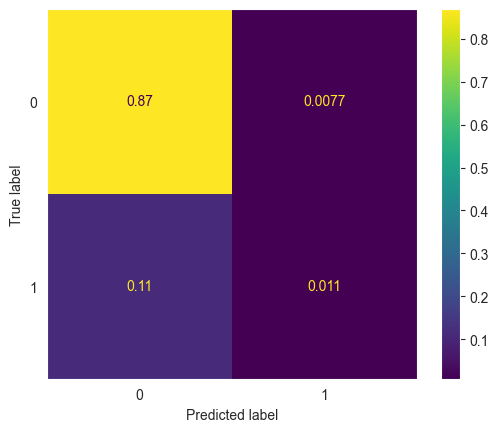

In [74]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

In [78]:
unique, counts = np.unique(y_test, return_counts=True)
counts/len(y_test)

array([0.877049, 0.122951])

Text(0.5, 0, 'Xgboost Feature Importance')

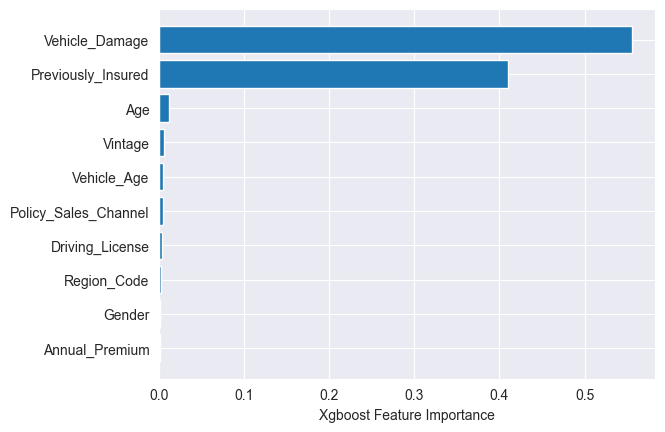

In [87]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(x_test.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

## Trying to Improve the Model